In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tueplots import bundles, figsizes

plt.rcParams.update(bundles.icml2022()) 
plt.rcParams.update(figsizes.icml2022_full())

plt.rcParams["figure.figsize"][1] *= 1.5
plt.rcParams["text.usetex"] = True

In [30]:

# Read the CSV file
vax = pd.read_csv("who_vax_country.tsv", sep="\t")

# Subset the data
vax = vax[vax['ANTIGEN_DESCRIPTION'] == "HPV Vaccination program coverage, first dose, females"]

# Convert COVERAGE to integer
vax['COVERAGE'] = vax['COVERAGE'].astype('Int64')

# Define who_countries as a dictionary
who_countries = {
    "AFR": ["Algeria", "Angola", "Benin", "Botswana", "Burkina Faso", "Burundi", "Cameroon", "Cape Verde", "Cabo Verde", "Central African Republic", "Chad", "Comoros", "Ivory Coast", "Democratic Republic of the Congo", "Equatorial Guinea", "Eritrea", "Ethiopia", "Gabon", "Gambia", "Ghana", "Guinea", "Guinea-Bissau", "Kenya", "Lesotho", "Liberia", "Madagascar", "Malawi", "Mali", "Mauritania", "Mauritius", "Mozambique", "Namibia", "Niger", "Nigeria", "Republic of the Congo", "Rwanda", "São Tomé and Príncipe", "Senegal", "Seychelles", "Sierra Leone", "South Africa", "South Sudan", "Eswatini", "Togo", "Uganda", "Tanzania", "Zambia", "Zimbabwe"],
    "AMR": ["Peru", "Paraguay", "Saint Kitts and Nevis", "Antigua and Barbuda", "Argentina", "Bahamas", "Barbados", "Belize", "Bolivia", "Brazil", "Canada", "Chile", "Colombia", "Costa Rica", "Cuba", "Dominica", "Dominican Republic", "Ecuador", "El Salvador", "Grenada", "Guatemala", "Guyana", "Haiti", "Honduras", "Jamaica", "Mexico", "Nicaragua", "Panama", "Saint Lucia", "Saint Vincent and the Grenadines", "Suriname", "Trinidad and Tobago", "the United States of America", "Uruguay", "Venezuela"],
    "SEAR": ["Bangladesh", "Bhutan", "Democratic People's Republic of Korea", "India", "Maldives", "Myanmar", "Nepal", "Sri Lanka", "Thailand", "Timor-Leste"],
    "EUR": ["Albania", "Andorra", "Armenia", "Austria", "Azerbaijan", "Belarus", "Belgium", "Bosnia and Herzegovina", "Bulgaria", "Croatia", "Cyprus", "Czech Republic", "Denmark", "Estonia", "Finland", "France", "Georgia", "Germany", "Greece", "Hungary", "Iceland", "Ireland", "Israel", "Italy", "Kazakhstan", "Kyrgyzstan", "Latvia", "Lithuania", "Luxembourg", "Malta", "Moldova", "Monaco", "Montenegro", "Netherlands", "North Macedonia", "Norway", "Poland", "Portugal", "Romania", "Russia", "San Marino", "Serbia", "Slovakia", "Slovenia", "Spain", "Sweden", "Switzerland", "Tajikistan", "Turkey", "Turkmenistan", "Ukraine", "United Kingdom", "Uzbekistan"],
    "EMR": ["Libya", "Afghanistan", "Bahrain", "Djibouti", "Egypt", "Iran", "Iraq", "Jordan", "Kuwait", "Israel", "Oman", "Pakistan", "Qatar", "Saudi Arabia", "Somalia", "Sudan", "Syria", "Tunisia", "United Arab Emirates", "Yemen", "Morocco"],
    "WPR": ["Australia", "Brunei", "Cambodia", "China", "Cook Islands", "Fiji", "Indonesia", "Japan", "Kiribati", "Laos", "Malaysia", "Marshall Islands", "Micronesia", "Mongolia", "Nauru", "New Zealand", "Niue", "Palau", "Papua New Guinea", "Philippines", "Samoa", "Singapore", "Solomon Islands", "South Korea", "Taiwan", "Tonga", "Tuvalu", "Vanuatu", "Vietnam"]
}

# Define name_recode as a dictionary
name_recode = {
    "Bolivia (Plurinational State of)": "Bolivia",
    "Brunei Darussalam": "Brunei",
    "Côte d'Ivoire": "Ivory Coast",
    "Czechia": "Czech Republic",
    "Lao People's Democratic Republic": "Laos",
    "Republic of Moldova": "Moldova",
    "Russian Federation": "Russia",
    "Sao Tome and Principe": "São Tomé and Príncipe",
    "Türkiye": "Turkey",
    "United States of America": "the United States of America",
    "Micronesia (Federated States of)": "Micronesia",
    "Netherlands (Kingdom of the)": "Netherlands",
    "Republic of Korea": "South Korea",
    "United Kingdom of Great Britain and Northern Ireland": "United Kingdom",
    "United Republic of Tanzania": "Tanzania"
}

# Recode the NAME column
vax['NAME'] = vax['NAME'].replace(name_recode)

# Create who_region_df
who_region_df = pd.DataFrame([
    (country, region) 
    for region, countries in who_countries.items() 
    for country in countries
], columns=['NAME', 'REGION'])

# Left join vax with who_region_df
vax = vax.merge(who_region_df, on='NAME', how='left')

# Read metadata
metadata = pd.read_csv("vax_metadata.csv", index_col=0)  # Adjust path if necessary

# Rename column
metadata = metadata.rename(columns={'ISO_3_CODE': 'CODE'})

# Select relevant columns from metadata
metadata_selected = metadata[['CODE', 'HPV_YEAR_INTRODUCTION', 'HPV_INT_DOSES']]

# Left join vax with metadata_selected
coverage_df_clean = vax.merge(metadata_selected, on='CODE', how='left')

# Update COVERAGE based on conditions
coverage_df_clean['COVERAGE'] = np.where(
    (coverage_df_clean['YEAR'] < coverage_df_clean['HPV_YEAR_INTRODUCTION']) | 
    (coverage_df_clean['HPV_INT_DOSES'] == "Not yet introduced"),
    0,
    coverage_df_clean['COVERAGE']
)

# Drop the HPV_YEAR_INTRODUCTION column
coverage_df_clean = coverage_df_clean.drop(columns=['HPV_YEAR_INTRODUCTION'])

# Assuming the previous code has been run, and we have coverage_df_clean
# For clarity, rename it to vax as in the original plotting code
vax = coverage_df_clean.copy()

# Define regions
regions = list(who_countries.keys())

# Compute aggregated data for regions (vax_name equivalent)
vax_name = vax.groupby(['REGION', 'YEAR'])['COVERAGE'].agg(['mean', 'std', 'count']).reset_index()
vax_name['se_coverage'] = vax_name['std'] / np.sqrt(vax_name['count'])
vax_name = vax_name.rename(columns={'mean': 'mean_coverage'})
vax_name = vax_name.drop(columns=['std', 'count'])  # Optional, to clean up


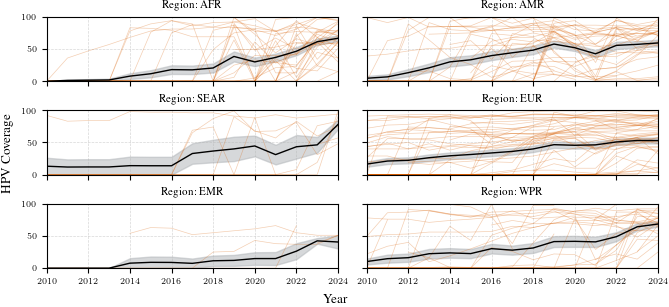

In [31]:
# TU Corporate Colors
TU_red = "#d95f02"
TU_gray = "#AFB3B7"

# Regions list (same as before)
regions = list(who_countries.keys())

fig, axes = plt.subplots(3, 2, sharex=True, sharey=True, constrained_layout=True)
axes = axes.flatten()

for idx, region in enumerate(regions):
    ax = axes[idx]
    region_data = vax_name[vax_name["REGION"] == region]
    country_data = vax[vax["REGION"] == region]

    # Plot individual country lines
    for country in country_data["NAME"].unique():
        subset = country_data[country_data["NAME"] == country]
        ax.plot(subset["YEAR"], subset["COVERAGE"],
                color=TU_red, alpha=0.3, linewidth=0.5)

    # Ribbon for ±SE
    ax.fill_between(region_data["YEAR"],
                    region_data["mean_coverage"] - region_data["se_coverage"],
                    region_data["mean_coverage"] + region_data["se_coverage"],
                    color=TU_gray, alpha=0.5)

    # Regional mean line
    ax.plot(region_data["YEAR"], region_data["mean_coverage"],
            color="black", linewidth=1)

    ax.set_title(f"Region: {region}")
    ax.set_ylim(0, 100)
    ax.set_xlim(vax["YEAR"].min(), vax["YEAR"].max())
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

# Common axis labels
fig.supxlabel("Year")
fig.supylabel("HPV Coverage")

plt.savefig("C:\\Users\\ettod\\Tubingen_exercises\\DataL\\vax_year.pdf")
plt.show()
